In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

2024-07-19 16:57:49.199017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 16:57:49.229159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 16:57:49.229233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 16:57:49.245877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 16:57:50.154965: W tensorflow/compiler/tf

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


### Load the data

In [3]:
# load the data
def load_pickle(file_name):
    return pd.read_pickle(file_name + '.pkl')

In [4]:
file_name = 'final_df'
df = load_pickle(data_directory + '/' + file_name)

In [24]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [25]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

### Training-Validation split

In [26]:
def train_test_split(df, train_perc, seed):
    
    shuffled_df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    tr_samples = int(len(df)*train_perc)
    
    train_df = shuffled_df.iloc[:tr_samples]
    
    test_df = shuffled_df.iloc[tr_samples:]
    
    return [train_df,test_df]

In [27]:
def create_dataset(df, batch_size , shuffle=False, use_object=False, dataset_repeat=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    # merge the two arrays
    if use_object:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    else:
        df['input'] = df['keypoints']

    if use_object:
        data = np.zeros((len(kpoints), 17*3+100))
    else:    
        data = np.zeros((len(kpoints), 17*3))
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
        
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    if shuffle:
        dataset = dataset.shuffle(len(data))

    if dataset_repeat:        
        dataset = dataset.repeat()
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset

In [28]:
train_perc = 0.75
train, val = train_test_split(df = df, train_perc = train_perc, seed = 42)

In [29]:
batch_s = 32
use_object = True

dataset_train = create_dataset(train, batch_s, shuffle=False, use_object=use_object)
train_steps = int(np.ceil(len(train)/batch_s))

dataset_val = create_dataset(val, batch_s, shuffle=False, use_object=use_object)
val_steps = int(np.ceil(len(val)/batch_s))

### Define the model

In [30]:
if use_object:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(17*3+100,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(15, activation='softmax')
    ])
else:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(17*3,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(15, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,287 (118.31 KB)

 Trainable params: 30,287 (118.31 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

results = model.fit(dataset_train,
                     epochs=1000,
                       steps_per_epoch=train_steps, 
                       validation_data=dataset_val, 
                       validation_steps=val_steps,
                        callbacks=[early_stop_callback])

Epoch 1/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1433 - loss: 2.5699 - val_accuracy: 0.4059 - val_loss: 1.9255
Epoch 2/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3514 - loss: 1.9667 - val_accuracy: 0.4441 - val_loss: 1.7653
Epoch 3/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3947 - loss: 1.8350 - val_accuracy: 0.4684 - val_loss: 1.7011
Epoch 4/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4222 - loss: 1.7748 - val_accuracy: 0.4807 - val_loss: 1.6559
Epoch 5/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4368 - loss: 1.7211 - val_accuracy: 0.4861 - val_loss: 1.6202
Epoch 6/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4485 - loss: 1.6962 - val_accuracy: 0.4937 - val_loss: 1.5997
Epoch 7/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4542 - loss: 1.6785 - val_accuracy: 0.4959 - val_loss: 1.5830
Epoch 8/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4527 - loss: 1.6610 - 

### Analyze the results

In [32]:
train_loss = results.history['loss']

val_loss = results.history['val_loss']

train_accuracy = results.history['accuracy']

val_accuracy = results.history['val_accuracy']

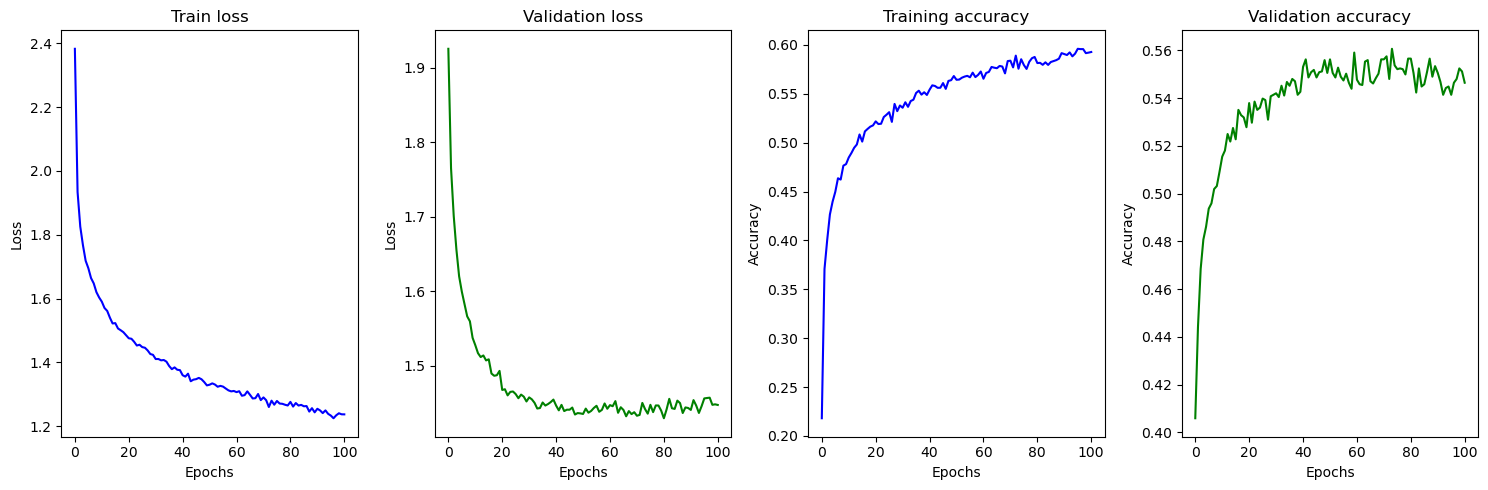

In [33]:
t = np.arange(len(train_accuracy))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.plot(t, train_loss, 'b')
ax1.set_title('Train loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(t, val_loss, 'g')
ax2.set_title('Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax3.plot(t, train_accuracy, 'b')
ax3.set_title('Training accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')

ax4.plot(t, val_accuracy, 'g')
ax4.set_title('Validation accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Results on the Validation set

In [35]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [37]:
# predict on the validation set
dataset_val = create_dataset(val, batch_s, shuffle=False, use_object=use_object, dataset_repeat=False)

y_pred = model.predict(dataset_val)
pred = np.argmax(y_pred, axis=1)

# confusion matrix
from sklearn.metrics import confusion_matrix

y_true = val['category']

conf_matrix = confusion_matrix(y_true, pred)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


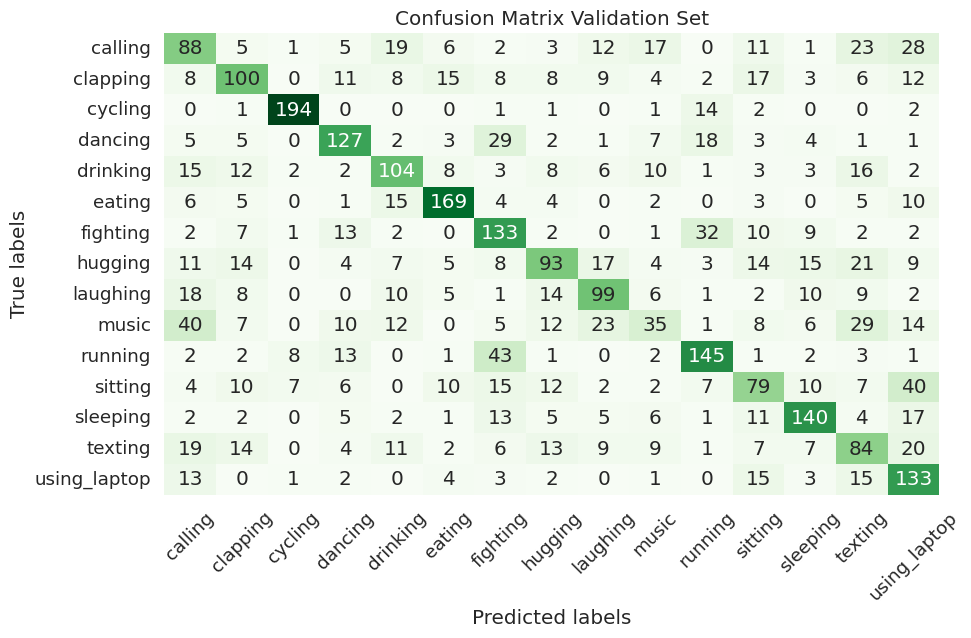

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.set(font_scale=1.2)  # Adjust font size

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Greens", cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xticks(rotation=45)

plt.xlabel('Predicted labels')

plt.ylabel('True labels')

plt.title('Confusion Matrix Validation Set')

plt.show()

In [39]:
def class_specific_metrics(cm, class_labels = [i for i in range(15)]):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [40]:
df = class_specific_metrics(conf_matrix)
df

,Accuracy,Sensitivity,Specificity,Precision
0,0.911746,0.398190,0.950495,0.377682
1,0.935556,0.473934,0.968697,0.520833
2,0.986667,0.898148,0.993183,0.906542
3,0.950159,0.610577,0.974167,0.625616
4,0.943175,0.533333,0.970220,0.541667
5,0.963492,0.754464,0.979494,0.737991
6,0.928889,0.615741,0.951943,0.485401
7,0.930476,0.413333,0.970256,0.516667
8,0.946032,0.535135,0.971669,0.540984
9,0.924127,0.173267,0.975577,0.327103


### Prediction on the training set


In [41]:
# predict on the training set
dataset_train = create_dataset(train, batch_s, shuffle=False, use_object=use_object, dataset_repeat=False)
y_pred_train = model.predict(dataset_train, steps=train_steps)

pred_train = np.argmax(y_pred_train, axis=1)

# confusion matrix
y_true_train = train['category']

conf_matrix_train = confusion_matrix(y_true_train, pred_train)

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


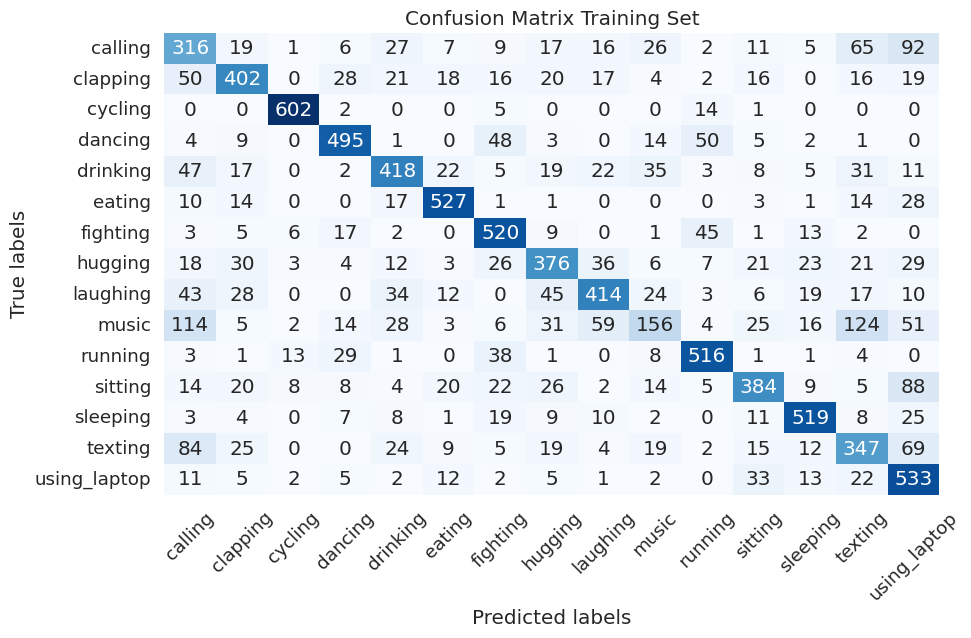

In [42]:
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.set(font_scale=1.2)  # Adjust font size

sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xticks(rotation=45)

plt.xlabel('Predicted labels')

plt.ylabel('True labels')

plt.title('Confusion Matrix Training Set')

plt.show()

In [43]:
df_train = class_specific_metrics(conf_matrix_train)
df_train

,Accuracy,Sensitivity,Specificity,Precision
0,0.925185,0.510501,0.954252,0.438889
1,0.956720,0.639110,0.979367,0.688356
2,0.993968,0.964744,0.996034,0.945055
3,0.972593,0.783228,0.986165,0.802269
4,0.956825,0.648062,0.979443,0.697830
5,0.979259,0.855519,0.987888,0.831230
6,0.967619,0.833333,0.977113,0.720222
7,0.953016,0.611382,0.976797,0.647160
8,0.956825,0.632061,0.981012,0.712565
9,0.932593,0.244514,0.982410,0.501608


### Testing set

In [49]:
test_df = load_pickle(data_directory + '/test_df')

In [50]:
test_df

,filename,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,"[0.07926996797323227, 0.5947930812835693, 0.56...","[0.2516569, 0.17761408, 0.04274578, 0.04146244...","[435, 876, 434, 747, 797]","[[0.41319000720977783, 0.052032001316547394, 0...","[[bathtub], [tub], [bath, towel], [punching, b..."
1,Image_2.jpg,"[0.0785704255104065, 0.43337151408195496, 0.58...","[0.22382939, 0.107774235, 0.08901217, 0.037059...","[762, 860, 726, 526, 415]","[[0.2788099944591522, -0.4242599904537201, -0....","[[restaurant], [tobacco, shop], [plane], [desk..."
2,Image_3.jpg,"[0.026546861976385117, 0.9105532765388489, 0.2...","[0.6181695, 0.08971589, 0.019042958, 0.0186859...","[974, 562, 980, 972, 862]","[[0.019871000200510025, 0.7510499954223633, -0...","[[geyser], [fountain], [volcano], [cliff], [to..."
3,Image_4.jpg,"[0.05568854138255119, 0.6325057744979858, 0.39...","[0.25478286, 0.08816597, 0.042543884, 0.038421...","[865, 399, 911, 917, 400]","[[0.5181999802589417, -0.48190000653266907, -0...","[[toyshop], [abaya], [wool], [comic, book], [a..."
4,Image_5.jpg,"[0.06054305285215378, 0.6548119187355042, 0.77...","[0.06376454, 0.05839194, 0.04397597, 0.0288917...","[465, 841, 590, 419, 681]","[[-1.02715003490448, -0.5592600107192993, -0.1...","[[bulletproof, vest], [sweatshirt], [hand, hel..."
...,...,...,...,...,...,...
5395,Image_5396.jpg,"[0.09091931581497192, 0.43842214345932007, 0.4...","[0.13928552, 0.076878965, 0.073724136, 0.06629...","[459, 638, 400, 911, 903]","[[1.0575000047683716, 1.347100019454956, 0.264...","[[brassiere], [maillot], [academic, gown], [wo..."
5396,Image_5397.jpg,"[0.05253060534596443, 0.9547996520996094, 0.27...","[0.17326465, 0.09512971, 0.034398936, 0.028374...","[525, 580, 807, 428, 842]","[[0.3268199861049652, -0.34040001034736633, -0...","[[dam], [greenhouse], [solar, dish], [barrow],..."
5397,Image_5398.jpg,"[0.030637364834547043, 0.6961045861244202, 0.4...","[0.2768016, 0.091625154, 0.07929682, 0.051239,...","[981, 921, 862, 781, 851]","[[0.7649499773979187, 0.6759799718856812, 0.68...","[[ballplayer], [book, jacket], [torch], [score..."
5398,Image_5399.jpg,"[0.06117207556962967, 0.32603949308395386, 0.5...","[0.29293764, 0.1566693, 0.032930996, 0.0255190...","[703, 608, 487, 414, 765]","[[0.6208399534225464, 0.5554400086402893, 0.94...","[[park, bench], [jean], [cellular, telephone],..."


In [56]:
test_df['keypoints'] = test_df['keypoints'].apply(lambda x: np.array(x).flatten())  
test_df['object'] = test_df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
test_df['obj_vector'] = test_df['obj_vector'].apply(lambda x: np.array(x))

test_df['obj_input'] = test_df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
test_df['keypoints'] = test_df['keypoints'].apply(lambda x: x.flatten())

if use_object:
    test_df['input'] = test_df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
else:
    test_df['input'] = test_df['keypoints']                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: cycling


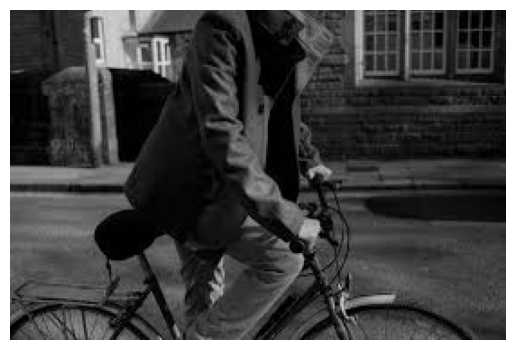

In [136]:
# choose a random image and predict
image = test_df.sample(1)

input = image['input'].values[0].reshape(1, -1)

y_pred = model.predict(input)

pred = np.argmax(y_pred)

print('Predicted class: ' + labels[pred])

image_path = data_directory + '/test/' + image['filename'].values[0]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()